# ExprOptimization.jl

ExprOptimization.jl is a Julia package for optimizing Julia expressions.  The package implements algorithms to optimize expression trees derived from a grammar to optimize a user-defined objective function.  The package depends on ExprRules.jl.

## Installation

To install the package:

    Pkg.add("ExprOptimization")

## Usage

To start using the package:

In [1]:
using ExprOptimization

## Example -- Symbolic Regression

We consider the example of finding an algebraic expression that approximates a given function.

First, we define a grammar:

In [2]:
const grammar = @grammar begin
    Real = x
    Real = Real * Real
    Real = Real + Real
    Real = Real - Real
    Real = |(1:5)
end

1: Real = x
2: Real = Real * Real
3: Real = Real + Real
4: Real = Real - Real
5: Real = 1
6: Real = 2
7: Real = 3
8: Real = 4
9: Real = 5


Create a custom symbol table and automatically populate it from the grammar.  This is not strictly necessary since ExprOptimization.jl can use the global symbol table, but it leads to much better performance.

In [3]:
const S = SymbolTable(grammar)

Dict{Symbol,Any} with 3 entries:
  :+ => +
  :- => -
  :* => *

Next, we define the ground truth expression and loss function by overloading the `loss` function in ExprOptimization.  The loss function returns the real-valued loss of a given expression tree.  The loss is minimized.

In [4]:
ground_truth(x) = x*x + 2x + 1
function loss(tree::RuleNode, grammar::Grammar)
    ex = get_executable(tree, grammar)
    los = 0.0
    for x = -5.0:1.0:5.0
        S[:x] = x
        los += abs2(Core.eval(S,ex) - ground_truth(x))
    end
    los
end

loss (generic function with 1 method)

Once these are defined, we can use any of the implemented algorithms to perform the optimization.

### Monte Carlo

Monte Carlo (MC) draws a number of random expression trees from the grammar and returns the one with the best loss.

In [5]:
?MonteCarlo

search: MonteCarlo MonteCarlos



```
MonteCarlo
```

Monte Carlo.

# Arguments:

  * `num_samples::Int`: number of samples
  * `max_depth::Int`: maximum depth of derivation tree


In [6]:
using Random
Random.seed!(10)
p = MonteCarlo(20000, 6)
results_mc = optimize(p, grammar, :Real, loss)
(results_mc.expr, results_mc.loss)

(:((x + 3) * x), 121.0)

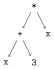

In [7]:
display(results_mc.tree, grammar)

## Genetic Programming

Genetic Programming (GP) is an evolutionary algorithm for trees.

See: Koza, "Genetic Programming: On the Programming of Computers by Means of Natural Selection", MIT Press, 1992.

In [8]:
?GeneticProgram

search: GeneticProgram GeneticPrograms



```
GeneticProgram
```

Genetic Programming.

# Arguments

  * `pop_size::Int`: population size
  * `iterations::Int`: number of iterations
  * `max_depth::Int`: maximum depth of derivation tree
  * `p_reproduction::Float64`: probability of reproduction operator
  * `p_crossover::Float64`: probability of crossover operator
  * `p_mutation::Float64`: probability of mutation operator
  * `init_method::InitializationMethod`: initialization method
  * `select_method::SelectionMethod`: selection method


In [9]:
Random.seed!(1)
p = GeneticProgram(1000,20,6,0.3,0.3,0.4)
results_gp = optimize(p, grammar, :Real, loss)
(results_gp.expr, results_gp.loss)

(:((x * 2 + (x * x - 3)) + 4), 0.0)

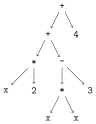

In [10]:
display(results_gp.tree, grammar)

## Grammatical Evolution

Grammatical Evolution (GE) is an evolutionary algorithm based on sequentializing the decisions in the derivation tree (e.g., using depth-first traversal order).  Optimization is performed over integer arrays using genetic algorithms.

See: C. Ryan, J.J. Collins, M. O'Neil, "Grammatical Evolution: Evolving Programs for an Arbitrary Language", in European Conference on Genetic Programming, Springer, 1998, pp. 83-96.

In [11]:
?GrammaticalEvolution

search: GrammaticalEvolution GrammaticalEvolutions



```
GrammaticalEvolution
```

Grammatical Evolution.

# Arguments

  * `grammar::Grammar`: grammar
  * `typ::Symbol`: start symbol
  * `pop_size::Int`: population size
  * `iterations::Int`: number of iterations
  * `init_gene_length::Int`: initial length of genotype integer array
  * `max_gene_length::Int`: maximum length of genotype integer array
  * `max_depth::Int`: maximum depth of derivation tree
  * `p_reproduction::Float64`: probability of reproduction operator
  * `p_crossover::Float64`: probability of crossover operator
  * `p_mutation::Float64`: probability of mutation operator
  * `select_method::SelectionMethod`: selection method (default: tournament selection)
  * `mutate_method::InitializationMethod`: mutation method (default: multi-mutate)


In [12]:
Random.seed!(1)
p = GrammaticalEvolution(grammar,:Real,1000,20,10,10,6,0.2,0.4,0.4; select_method=GrammaticalEvolutions.TruncationSelection(300))
results_ge = optimize(p, grammar, :Real, loss)
(results_ge.expr, results_ge.loss)

(:(x * ((5 + x) - 3) + 1), 0.0)

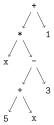

In [13]:
display(results_ge.tree, grammar)

## Cross-Entropy Method

The Cross-Entropy (CE) Method is a population-based optimization algorithm based on repeatedly estimating the probability distribution of good solutions.  This implementation uses a probabilistic grammar to represent the distributions.

See: Rubinstein, "Optimization of Computer Simulation Models with Rare Events", European Journal of Operations Research, 99, 89-112, 1197

In [14]:
?CrossEntropy

search: CrossEntropy CrossEntropys



```
CrossEntropy
```

Cross Entropy method.

# Arguments

  * `pop_size::Int`: population size
  * `iterations::Int`: number of iterations
  * `max_depth::Int`: maximum depth of derivation tree
  * `top_k::Int`: top k elite samples used in selection
  * `p_init::Float64`: initial value when fitting MLE
  * `init_method::InitializationMethod`: Initialization method


In [15]:
Random.seed!(1)
p = CrossEntropy(1000,20,6,500)
results_ce = optimize(p, grammar, :Real, loss)
(results_ce.expr, results_ce.loss)

(:(x * (2 + x) + 1), 0.0)

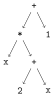

In [16]:
display(results_ce.tree, grammar)

## PIPE

Probabilistic Incremental Program Evolution (PIPE) is an expression tree optimization algorithm based on the probabilistic prototype tree (PPT) model.

See: Salustowicz and Schmidhuber, "Probabilistic Incremental Program Evolution", Evolutionary Computation, vol. 5, no. 2, pp. 123-141, 1997.

In [17]:
?PIPE

search: PIPE PIPEs Pipe pipeline PipeBuffer partialsortperm partialsortperm!



```
PIPE
```

Probabilistic Incremental Program Evolution. Example parameters from paper are indicated in parentheses)

# Arguments:

  * `ppt_params::PPT`: parameters for PPT  (e.g., [0.8, 0.2])
  * `pop_size::Int`: population size
  * `iterations::Int`: number of iterations
  * `p_elitist::Float64`: elitist update probability (e.g., 0.2)
  * `c::Float64`: learning rate multiplier (e.g., 0.1)
  * `α::Float64`: learning rate (e.g., 0.05)
  * `ϵ::Float64`: fitness constant (e.g., 1)
  * `p_mutation::Float64`: mutation probability (e.g., 0.2)
  * `β::Float64`: mutation rate (e.g., 0.6)
  * `p_threshold::Float64`: prune threshold (e.g., 0.999)
  * `max_depth::Int`: maximum depth of derivation tree


In [18]:
Random.seed!(3)
p = PIPE(PPT(0.8),1000,20,0.2,0.1,0.05,1,0.2,0.6,0.999,6)
results_pipe = optimize(p, grammar, :Real, loss)
(results_pipe.expr, results_pipe.loss)

(:(x * (1x - ((5 - 1) - 5)) + (1 + x)), 0.0)

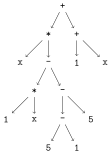

In [19]:
display(results_pipe.tree, grammar)